In [1]:
import os
import json
import time
import copy
from datetime import datetime
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import lovely_tensors as lt # can be removed
import numpy as np
import dill
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from fl2o.optimizee import MLPOptee, CustomParams
from fl2o.optimizee_modules import MetaParameter
from fl2o.optimizer import GD, Adam, FGD, AFOGD, CFGD, CFGD_ClosedForm, L2O_Update
from fl2o.l2o import L2O
from fl2o.data import MNIST, CustomTask, generate_least_squares_task
from fl2o.training import do_fit, find_best_lr, meta_train, get_optimal_lr
from fl2o.utils import dict_to_str, plot_log, plotter, plot_metric, apply_publication_plt_settings, plot_strategy

lt.monkey_patch() # can be removed

DATA_PATH = os.getenv("DATA_PATH")
CKPT_PATH = os.getenv("CKPT_PATH")
DEVICE = os.getenv("DEVICE", "cpu")

print(f"{DATA_PATH=}\n{CKPT_PATH=}\n{DEVICE=}")

DATA_PATH='/home/datalab/notebooks/JanSobotka/fl2o/fractional-learning-to-optimize/data'
CKPT_PATH='/home/datalab/notebooks/JanSobotka/fl2o/fractional-learning-to-optimize/ckpt'
DEVICE='cuda:3'


In [3]:
### load previous checkpoint (and skip meta-training of a new l2O optimizer)
ckpt = torch.load(
    os.path.join(
        CKPT_PATH,
        "l2o",
        "04-02_11-17__L2O__CFGD",
        # "ckpt.pt"
        "meta_training",
        "20.pt",
    ),
    map_location=torch.device(DEVICE),
    pickle_module=dill,
)
l2o_dict = ckpt["l2o_dict"]
l2o_dict_best = ckpt["l2o_dict_best"]
log = ckpt["log"]
config = ckpt["config"]
print(json.dumps(config, indent=4, default=str))

{
    "time": "04-02_11-17",
    "data": {
        "data_cls": "<class 'fl2o.data.MNIST'>",
        "data_config": {
            "device": "cuda:0",
            "preload": true
        }
    },
    "optee": {
        "optee_cls": "<class 'fl2o.optimizee.MLPOptee'>",
        "optee_config": {
            "layer_sizes": [
                20
            ],
            "act_fn": "ReLU()"
        }
    },
    "opter": {
        "opter_cls": "<class 'fl2o.l2o.L2O'>",
        "opter_config": {
            "in_dim": 3,
            "out_dim": 3,
            "hidden_sz": 40,
            "in_features": [
                "grad",
                "iter_num_enc"
            ],
            "base_opter_cls": "<class 'fl2o.optimizer.CFGD'>",
            "base_opter_config": {
                "lr": 0.05,
                "alpha": null,
                "beta": null,
                "c": null,
                "s": 1,
                "version": "NA",
                "init_points": null,
                "devi

In [ ]:
### load previous checkpoint (and skip meta-training of a new l2O optimizer)
ckpt_2 = torch.load(
    os.path.join(
        CKPT_PATH,
        "l2o",
        "02-02_10-54__L2O__L2O_Update",
        "ckpt.pth"
        # "meta_training",
        # "20.pt",
    ),
    map_location=torch.device(DEVICE),
    pickle_module=dill,
)
l2o_dict_2 = ckpt_2["l2o_dict"]
l2o_dict_best_2 = ckpt_2["l2o_dict_best"]
log_2 = ckpt_2["log"]
config_2 = ckpt_2["config"]
print(json.dumps(config_2, indent=4, default=str))

## Least Squares

$$
\begin{aligned}
    \min_{x} f(x) = \frac{1}{2} ||W^T x - y||_2^2 \\
    \text{where } W \in \mathbb{R}^{d \times m}, y \in \mathbb{R}^m
\end{aligned}
$$

### Meta-training

In [ ]:
config = {
    "time": datetime.now().strftime("%d-%m_%H-%M"),
}

### data (task)
config["data"] = {
    "d": 100,
    "m": 100,
    "data_cls": CustomTask,
}
config["data"]["data_config"] = {
    "task": generate_least_squares_task,
    "task_config": {
        "d": config["data"]["d"],
        "m": config["data"]["m"],
        "verbose": False,
        "device": DEVICE,
    },
}


### optimizee
config["optee"] = {
    "optee_cls": CustomParams,
    "optee_config": {
        "dim": (1, config["data"]["d"]),
        "init_params": "randn",
    },
}

### optimizer L2O-CFGD
# config["opter"] = {
#     "opter_cls": L2O,
#     "opter_config": {
#         "in_dim": 3, # len(in_features) + 1
#         "out_dim": 3,
#         "hidden_sz": 40,
#         "in_features": ("grad", "iter_num_enc"),
#         "base_opter_cls": CFGD_ClosedForm,
#         "base_opter_config": {
#             "lr": get_optimal_lr,
#             "gamma": None,
#             "c": None,
#             "version": "NA",
#             "init_points": [torch.randn(1, config["data"]["d"], requires_grad=False, device=DEVICE)],
#             "device": DEVICE,
#         },
#         "params_to_optimize": {
#             # "gamma": {
#             #     "idx": 0,
#             #     "act_fns": ("identity", "diag"),
#             # },
#             # "gamma": {
#             #     "idx": 0,
#             #     "act_fns": ("alpha_to_gamma", "diag"),
#             #     "beta": 0.,
#             # },
#             "gamma": {
#                 "idx": (0, 1),
#                 "act_fns": ("alpha_beta_to_gamma", "diag"),
#             },
#             "c": {
#                 "idx": 2,
#                 "act_fns": ("identity",),
#             },
#         },
#     },
# }

### optimizer L2O
config["opter"] = {
    "opter_cls": L2O,
    "opter_config": {
        "in_dim": 3, # len(in_features) + 1
        "out_dim": 1,
        "hidden_sz": 40,
        "in_features": ("grad", "iter_num_enc"),
        "base_opter_cls": L2O_Update,
        "base_opter_config": {
            "lr": get_optimal_lr,
            "device": DEVICE,
        },
        "params_to_optimize": {
            "update": {
                "idx": 0,
                "act_fns": ("identity",),
            },
        },
    },
}

### meta-training config
config["meta_training_config"] = {
    "meta_opter_cls": optim.Adam,
    "meta_opter_config": {
        "lr": 1e-3,
    },
    "n_runs": 2000,
    "unroll": 20,
    "loggers": [
        # {
        #     "every_nth_run": 20,
        #     "logger_fn": partial(plotter, to_plot="gamma"),
        # },
        # {
        #     "every_nth_run": 20,
        #     "logger_fn": partial(plotter, to_plot="c"),
        # }
    ],
}

### other
config.update({
    "n_iters": 800,
    "l2o_dict": None,
    "additional_metrics": {
        # "gamma": lambda opter, **kwargs: \
        #     # opter.base_opter.param_groups[0]["gamma"].item() \
        #     opter.base_opter.param_groups[0]["gamma"].mean().item() \
        #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("gamma", None),
        # "c": lambda opter, **kwargs: \
        #     # opter.base_opter.param_groups[0]["c"].item() \
        #     opter.base_opter.param_groups[0]["c"].mean().item() \
        #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("c", None),
        # "l2_dist(x_tik*, x)": lambda task, optee, **kwargs: \
        #     torch.norm(task["x_tik_solution"](gamma=1., c=1) - optee.params.detach(), p=2).item(),
        # "l2_dist(x*, x)": lambda task, optee, **kwargs: \
        #     torch.norm(task["x_solution"] - optee.params.detach(), p=2).item(),
    },
    "ckpt_config": {
        "ckpt_every_nth_run": 50,
        "ckpt_dir": os.path.join(
            CKPT_PATH,
            "l2o",
            config["time"] + "__"\
                + config["opter"]["opter_cls"].__name__ + "__"\
                + config["opter"]["opter_config"]["base_opter_cls"].__name__,
        ),
    },
    "device": DEVICE,
    "seed": 0,
})
config["ckpt_config"]["ckpt_dir_meta_training"] = os.path.join(
    config["ckpt_config"]["ckpt_dir"],
    "meta_training",
)
config["ckpt_config"]["ckpt_dir_meta_testing"] = os.path.join(
    config["ckpt_config"]["ckpt_dir"],
    "meta_testing",
)

### make dirs
os.makedirs(config["ckpt_config"]["ckpt_dir"], exist_ok=True)
os.makedirs(config["ckpt_config"]["ckpt_dir_meta_training"], exist_ok=True)
os.makedirs(config["ckpt_config"]["ckpt_dir_meta_testing"], exist_ok=True)

### save config
with open(os.path.join(config["ckpt_config"]["ckpt_dir"], "config.json"), "w") as f:
    json.dump(config, f, indent=4, default=str)

print(f"Path to checkpoints: {config['ckpt_config']['ckpt_dir']}")

In [ ]:
### meta train
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
l2o_dict, l2o_dict_best, log = meta_train(
    config=config,
    ### keep meta-training
    # l2o_dict=l2o_dict,
    # l2o_dict_best=l2o_dict_best,
    # log=log,
)

### save final checkpoint
torch.save({
    "l2o_dict": l2o_dict,
    "l2o_dict_best": l2o_dict_best,
    "log": log,
    "config": config,
}, os.path.join(config["ckpt_config"]["ckpt_dir"], "ckpt.pth"), pickle_module=dill)

plt.plot(log["loss_sum"])

### Meta-testing

In [ ]:
### meta-testing config
test_d, test_m = 100, 100
n_test_runs = 10
test_run_iters = 500
test_runs_seed = 1

runs = dict()
c_palette = list(plt.cm.tab10.colors)

update_config_base = dict()
update_config_base["n_iters"] = test_run_iters
update_config_base["data"] = {
    "d": test_d,
    "m": test_m,
    "data_cls": CustomTask,
    "data_config": {
        "task": generate_least_squares_task,
        "task_config": {
            "d": test_d,
            "m": test_m,
            "verbose": False,
            "device": DEVICE,
        },
    },
}
update_config_base["optee"] = {
    "optee_cls": CustomParams,
    "optee_config": {
        "dim": (1, test_d),
        "init_params": "randn",
    },
}
update_config_base["additional_metrics"] = {
    # "l2_dist(x_tik*, x)": lambda task, optee, **kwargs: \
    #     torch.norm(task["x_tik_solution"](gamma=gamma, c=1) - optee.params.detach(), p=2).item(),
    # "l2_dist(x*, x)": lambda task, optee, **kwargs: \
    #     torch.norm(task["x_solution"] - optee.params.detach(), p=2).item(),
    # "x": lambda y_hat, y, optee: optee.params.detach().cpu().numpy(),
    "cos_sim(d, x.grad)": lambda opter, **kwargs: \
        torch.cosine_similarity(
            opter.state[0]["last_update"].flatten() if "last_update" in opter.state[0] else opter.param_groups[0]["last_update"].flatten(),
            opter.state[0]["last_grad"].flatten() if "last_grad" in opter.state[0] else opter.param_groups[0]["last_grad"].flatten(),
            dim=0
        ).item(),
    "last_lr": lambda opter, **kwargs: \
        opter.state[0]["last_lr"] if "last_lr" in opter.state[0] else opter.param_groups[0]["last_lr"],
}

In [ ]:
### GD
runs["GD"] = {
    "update_config": {
        **update_config_base,
        "opter": {
            "opter_cls": GD,
            "opter_config": {
                "lr": get_optimal_lr,
                "device": DEVICE,
            },
        },
    },
    "plot_config": {
        "color": "black",
        "linestyle": "dashed",
    },
}

In [ ]:
### Adam
runs["Adam"] = {
    "update_config": {
        **update_config_base,
        "opter": {
            "opter_cls": Adam,
            "opter_config": {
                "lr": get_optimal_lr,
                "device": DEVICE,
            },
        },
    },
    "plot_config": {
        "color": "gray",
        "linestyle": "dashed",
    },
}

In [ ]:
### NA-CFGD
for gamma in [0.15]:
    runs[r"NA-CFGD, $\gamma$=" + str(gamma)] = {
        "update_config": {
            **update_config_base,
            "opter": {
                "opter_cls": CFGD_ClosedForm,
                "opter_config": {
                    "lr": get_optimal_lr,
                    "gamma": gamma,
                    "c": 1.,
                    "version": "NA",
                    "init_points": None,
                    "device": DEVICE,
                },
            },
        },
        "plot_config": {
            "linestyle": "dashed",
            "color": c_palette[1],
        },
    }

In [ ]:
### AT-CFGD
for gamma in [-0.15]:
    runs[r"AT-CFGD, $\gamma$=" + str(gamma)] = {
        "update_config": {
            **update_config_base,
            "opter": {
                "opter_cls": CFGD_ClosedForm,
                "opter_config": {
                    "lr": get_optimal_lr,
                    "gamma": gamma,
                    "c": None,
                    "version": "AT",
                    "init_points": [torch.randn(1, test_d, requires_grad=False, device=DEVICE)],
                    "device": DEVICE,
                },
            },
        },
        "plot_config": {
            "linestyle": "dashed",
            "color": c_palette[0],
        },
    }

In [ ]:
### L2O
runs["L2O"] = {
    "update_config": {
        "n_iters": update_config_base["n_iters"],
        "data": update_config_base["data"],
        "optee": update_config_base["optee"],
        "additional_metrics": {
            "cos_sim(d, x.grad)": lambda opter, **kwargs: \
                torch.cosine_similarity(
                    opter.base_opter.state[0]["last_update"].flatten(),
                    opter.base_opter.state[0]["last_grad"].flatten(),
                    dim=0
                ).item(),
            "last_lr": lambda opter, **kwargs: \
                opter.base_opter.state[0]["last_lr"].item() if type(opter.base_opter.state[0]["last_lr"]) == torch.Tensor else opter.base_opter.state[0]["last_lr"],
        },
        # "l2o_dict": l2o_dict_2,
        "l2o_dict": l2o_dict_best_2["best_l2o_dict"],
    },
    "plot_config": {
        "linestyle": "dashed",
        "color": c_palette[2],
    },
}

In [ ]:
### L2O-CFGD
runs["L2O-CFGD"] = {
    "update_config": {
        "n_iters": test_run_iters,
        "data": update_config_base["data"],
        "optee": update_config_base["optee"],
        "additional_metrics": {
            # "gamma": lambda opter, **kwargs: \
            #     # opter.base_opter.param_groups[0]["gamma"].item() \
            #     opter.base_opter.param_groups[0]["gamma"].detach().cpu().numpy() \
            #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("gamma", None),
            "c": lambda opter, **kwargs: \
                # opter.base_opter.param_groups[0]["c"].item() \
                opter.base_opter.param_groups[0]["c"].detach().cpu().numpy() \
                if hasattr(opter, "base_opter") else opter.param_groups[0].get("c", None),
            "alpha": lambda opter, **kwargs: \
                # opter.base_opter.param_groups[0]["gamma"].item() \
                opter.base_opter.param_groups[0]["alpha"] \
                if hasattr(opter, "base_opter") else opter.param_groups[0].get("alpha", None),
            "beta": lambda opter, **kwargs: \
                # opter.base_opter.param_groups[0]["c"].item() \
                opter.base_opter.param_groups[0]["beta"] \
                if hasattr(opter, "base_opter") else opter.param_groups[0].get("beta", None),
            "grad": lambda opter, **kwargs: \
                opter.base_opter.state[0]["last_grad"].detach().cpu().numpy() \
                if hasattr(opter, "base_opter") else opter.state[0]["last_grad"].detach().cpu().numpy(),
            "cos_sim(d, x.grad)": lambda opter, **kwargs: \
                torch.cosine_similarity(
                    opter.base_opter.state[0]["last_update"].flatten(),
                    opter.base_opter.state[0]["last_grad"].flatten(),
                    dim=0
                ).item(),
            "last_lr": lambda opter, **kwargs: \
                opter.base_opter.state[0]["last_lr"].item() if type(opter.base_opter.state[0]["last_lr"]) == torch.Tensor else opter.base_opter.state[0]["last_lr"],
        },
        # "l2o_dict": l2o_dict,
        "l2o_dict": l2o_dict_best["best_l2o_dict"],
    },
    "plot_config": {
        # "color": "orange",
        "color": c_palette[3],
        # "linewidth": 1.5,
    },
}

In [ ]:
### run all
for run_name in runs.keys():
    ### remove all non-alphanumeric characters from run_name
    run_name_clean = ''.join(e for e in run_name if e.isalnum())
    run_nickname = f"{run_name_clean}__{test_d}d_{test_m}m_{n_test_runs}runs_{test_run_iters}iters_{test_runs_seed}seed"
    
    run_config = copy.deepcopy(config)
    if "update_config" in runs[run_name] and runs[run_name]["update_config"] is not None:
        run_config.update(runs[run_name]["update_config"])
    print(f"{run_name}:")
    
    ### check if already run    
    # already loaded?
    if "log" in runs[run_name]:
        print("  > Already run.")
        continue

    # already saved?
    if "l2o" in run_name.lower():
        if CKPT_PATH in run_config["ckpt_config"]["ckpt_dir"]:
            save_to = os.path.join(run_config["ckpt_config"]["ckpt_dir_meta_testing"], run_nickname + ".pt")
        else:
            ckpt_dir_local = os.path.basename(run_config["ckpt_config"]["ckpt_dir"])
            save_to = os.path.join(CKPT_PATH, "l2o", ckpt_dir_local, "meta_testing", run_nickname + ".pt")
    else: # baseline
        save_to = os.path.join(CKPT_PATH, "baselines",  run_nickname + ".pt")
    if os.path.exists(save_to):
    # if os.path.exists(save_to) and "l2o" not in run_name.lower():
        print(f"  > Already saved. Only loading...\n  > {save_to}")
        runs[run_name] = torch.load(save_to, map_location=torch.device(DEVICE), pickle_module=dill)
        continue

    torch.manual_seed(test_runs_seed)
    np.random.seed(test_runs_seed)

    if "lr" in run_config["opter"]["opter_config"] \
        and run_config["opter"]["opter_config"]["lr"] == find_best_lr:
        print("  > Finding best lr...")
        run_config["opter"]["opter_config"]["lr"] = find_best_lr(
            opter_cls=run_config["opter"]["opter_cls"],
            opter_config=run_config["opter"]["opter_config"],
            optee_cls=run_config["optee"]["optee_cls"],
            optee_config=run_config["optee"]["optee_config"],
            data_cls=run_config["data"]["data_cls"],
            data_config=run_config["data"]["data_config"],
            # loss_fn=run_config["loss_fn"],
            n_iters=120,
            n_tests=1,
            consider_metric="loss",
            lrs_to_try=[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
        )
        print(f"  > Best lr: {run_config['opter']['opter_config']['lr']}")

    print("  > Running...")
    runs[run_name]["log"] = dict()
    for i in range(n_test_runs):
        print(f"    > Run {i+1}/{n_test_runs}...")

        ### check if L2O has been meta-trained
        assert not run_config["opter"]["opter_cls"] == L2O or run_config["l2o_dict"] is not None

        curr_log = do_fit(
            opter_cls=run_config["opter"]["opter_cls"],
            opter_config=run_config["opter"]["opter_config"],
            optee_cls=run_config["optee"]["optee_cls"],
            optee_config=run_config["optee"]["optee_config"],
            data_cls=run_config["data"]["data_cls"],
            data_config=run_config["data"]["data_config"],
            n_iters=run_config["n_iters"],
            l2o_dict=run_config["l2o_dict"],
            in_meta_training=False,
            additional_metrics=run_config["additional_metrics"],
        )[0]

        for metric_name in curr_log.keys():
            if metric_name not in runs[run_name]["log"]:
                runs[run_name]["log"][metric_name] = []
            runs[run_name]["log"][metric_name].append(curr_log[metric_name])

    runs[run_name]["config"] = run_config

    ### save results
    torch.save(runs[run_name], save_to, pickle_module=dill)

In [ ]:
apply_publication_plt_settings(font_size=16, dpi=600, figsize=(5, 3.5))

In [ ]:
### plotting config
metric = "loss"
show_max_iters = test_run_iters
log_metric = True
conv_window = 5

### where to save the figure
fig_dir = "../results/publication/quadratic/src"
fig_name = f"{metric}_{test_d}d_{test_m}m_{show_max_iters}iters.pdf"
if log_metric:
    fig_name = f"log_{fig_name}"
save_fig_to_path = os.path.join(fig_dir, fig_name)
save_fig_to_path = None # don't save
print(f"Final destination: {save_fig_to_path if save_fig_to_path is not None else 'None'}")

In [ ]:
plot_metric(
    baselines={
        k: r for k, r in runs.items() if "L2O-CFGD" not in k
    },
    l2os={
        k: r for k, r in runs.items() if "L2O-CFGD" in k
    },
    metric=metric,
    show_max_iters=show_max_iters,
    log_metric=log_metric,
    with_err_bars=True,
    conv_window=conv_window,
    save_fig_to_path=save_fig_to_path,
)

In [ ]:
plot_log(
    runs,
    only_metrics=["loss", "cos_sim(d, x.grad)", "last_lr"],
    log_metrics=["loss", "l2_dist(x_tik*, x)", "l2_dist(x*, x)"],
    conv_win=1,
    min_max_y_config={
        "last_lr": (0, 100),
    },
    # save_to=os.path.join(
    #     config["ckpt_config"]["ckpt_dir"],
    #     f"loss_cos_sim_l2o_best_dict_{test_d}d_{test_m}m_{n_test_runs}runs_{test_run_iters}iters.png"
    # ),
)

### Analyze strategy

#### Single parameter

In [ ]:
### plotting config
to_plot_label = r"$c$"
to_plot_label_cleaned = ''.join(e for e in to_plot_label if e.isalnum())
to_plot = np.stack(runs["L2O-CFGD"]["log"][to_plot_label_cleaned])[0].squeeze()  # (n_test_runs, n_iters, D)

### where to save the figure
fig_dir = "../results/publication/quadratic/src"
fig_name = f"{to_plot_label_cleaned}_{test_d}d_{test_m}m_{test_run_iters}iters.pdf"
save_fig_to_path = os.path.join(fig_dir, fig_name)
# save_fig_to_path = None # don't save
print(f"Final destination: {save_fig_to_path if save_fig_to_path is not None else 'None'}")

In [ ]:
plot_strategy(
    to_plot=to_plot,
    y_label=to_plot_label,
    save_fig_to_path=save_fig_to_path,
)

#### Multiple parameters
- How do alphas, betas, cs and grads correlate with each other?

In [ ]:
alphas = np.stack(runs["L2O-CFGD"]["log"]["alpha"]).reshape(n_test_runs, test_run_iters, -1)
betas = np.stack(runs["L2O-CFGD"]["log"]["beta"]).reshape(n_test_runs, test_run_iters, -1)
cs = np.stack(runs["L2O-CFGD"]["log"]["c"]).reshape(n_test_runs, test_run_iters, -1)  # (n_test_runs, n_iters, D)
grads = np.stack(runs["L2O-CFGD"]["log"]["grad"]).reshape(n_test_runs, test_run_iters, -1)  # (n_test_runs, n_iters, D)

In [ ]:
max_components = 200
component_idxs = np.random.choice(alphas.shape[-1], size=max_components, replace=False)

In [ ]:
test_run_idx = 0
iters_to_show = [0, 1, 2, 5, 20]

# fig = plt.figure(figsize=(14, 18), facecolor="white")
fig = plt.figure()
# fig.suptitle("L2O + CFGD_ClosedForm")
ax_idx = 1

for i, iter_idx in enumerate(iters_to_show):
    ax = fig.add_subplot(len(iters_to_show), 3, ax_idx)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ### alphas
    sns.scatterplot(
        x=grads[test_run_idx, iter_idx, component_idxs],
        y=alphas[test_run_idx, iter_idx, component_idxs],
        ax=ax,
    )
    if i == len(iters_to_show) - 1:
        ax.set_xlabel(r"$\partial_{x_j} f(x_j)$")
    ax.set_ylabel(r"$\alpha$")
    # ax.set_title(fr"Iteration {iter_idx}")

    ### betas
    ax = fig.add_subplot(len(iters_to_show), 3, ax_idx + 1)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    sns.scatterplot(
        x=grads[test_run_idx, iter_idx, component_idxs],
        y=betas[test_run_idx, iter_idx, component_idxs],
        ax=ax,
    )
    if i == len(iters_to_show) - 1:
        ax.set_xlabel(r"$\partial_{x_j} f(x_j)$")
    ax.set_ylabel(r"$\beta$")
    ax.set_title(fr"Iteration {iter_idx}", pad=10)
    # ax.set_title(fr"$\beta$ (iter {iter_idx})")

    ### cs
    ax = fig.add_subplot(len(iters_to_show), 3, ax_idx + 2)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    sns.scatterplot(
        x=grads[test_run_idx, iter_idx, component_idxs],
        y=cs[test_run_idx, iter_idx, component_idxs],
        ax=ax,
    )
    if i == len(iters_to_show) - 1:
        ax.set_xlabel(r"$\partial_{x_j} f(x_j)$")
    ax.set_ylabel(r"$c$")
    # ax.set_title(fr"$c$ (iter {iter_idx})")

    ax_idx += 3

# fig.tight_layout(h_pad=1.5)
# save_to = os.path.join(
#     config["ckpt_config"]["ckpt_dir"],
#     f"strategy_grad_alpha_beta_c_{test_d}d_{test_m}m_{n_test_runs}runs_{test_run_iters}iters.png"
# )
# fig.savefig(save_to)
plt.tight_layout(h_pad=2.2)
plt.show()

fig.savefig("../results/strategy.eps", bbox_inches="tight")

#### Run LCFGD

In [ ]:
### collect
# gammas = np.stack(runs["L2O + CFGD_ClosedForm"]["log"]["gamma"])
# gammas = gammas.T.diagonal().transpose(1, 0, 2)  # (n_test_runs, n_iters, D)

alphas = np.stack(runs["L2O-CFGD"]["log"]["alpha"]).reshape(n_test_runs, test_run_iters, -1)
alphas_mean = alphas.mean((0,2))
betas = np.stack(runs["L2O-CFGD"]["log"]["beta"]).reshape(n_test_runs, test_run_iters, -1)
betas_mean = betas.mean((0,2))
cs = np.stack(runs["L2O-CFGD"]["log"]["c"]).reshape(n_test_runs, test_run_iters, -1)  # (n_test_runs, n_iters, D)
cs_mean = cs.mean((0,2))
grads = np.stack(runs["L2O-CFGD"]["log"]["grad"]).reshape(n_test_runs, test_run_iters, -1)  # (n_test_runs, n_iters, D)

gammas = betas - ((1 - alphas) / (2 - alphas))
gammas_mean = gammas.mean((0,2))

In [ ]:
# alphas_to_set = torch.ones(test_run_iters)
# alphas_to_set[:10] = 0.1
# alphas_to_set[10:20] = 0.5
# alphas_to_set[20:50] = 0.9
# alphas_to_set[50:] = 0.99

# cs_to_set = torch.zeros(test_run_iters)
# cs_to_set[:5] = -0.5
# cs_to_set[5:20] = 0.1

In [ ]:
lcfgd_run_name = r"LCFGD"
runs[lcfgd_run_name] = dict()

### Closed-form CFGD
# lcfgd_config = {
#     "update_config": {
#         **update_config_base,
#         "opter": {
#             "opter_cls": CFGD_ClosedForm,
#             "opter_config": {
#                 "lr": get_optimal_lr,
#                 "gamma": gammas_mean,
#                 # "gamma": torch.from_numpy(gammas[1]).to(DEVICE),

#                 "c": 1.,
#                 "version": "NA",
#                 "init_points": None,
                
#                 # "c": None,
#                 # "version": "AT",
#                 # "init_points": [torch.randn(1, test_d, requires_grad=False, device=DEVICE)],

#                 "gamma_per_step": True,
#                 "device": DEVICE,
#             },
#         },
#     },
#     "plot_config": {
#         "linestyle": "dashed",
#         "color": "green",
#     },
# }

### general CFGD
lcfgd_config = {
    "update_config": {
        **update_config_base,
        "opter": {
            "opter_cls": CFGD,
            "opter_config": {
                "lr": get_optimal_lr,
                "alpha": torch.from_numpy(alphas_mean).to(DEVICE).clip(None, 0.99),
                # "alpha": alphas_to_set.to(DEVICE),
                "beta": torch.from_numpy(betas_mean).to(DEVICE),
                # "c": torch.from_numpy(cs_mean).to(DEVICE),
                # "c": cs_to_set.to(DEVICE),
                "s": 1,
                
                # "version": "NA",
                # "init_points": None,
                
                "version": "AT",
                "init_points": [torch.randn(1, test_d, requires_grad=False, device=DEVICE)],

                "device": DEVICE,
            },
        },
    },
    "plot_config": {
        "linestyle": "dashed",
        "color": "green",
    },
}

runs[lcfgd_run_name]["config"] = copy.deepcopy(config)
runs[lcfgd_run_name]["config"].update(lcfgd_config["update_config"])
# runs[lcfgd_run_name]["config"]["data"]["data_config"]["device"] = DEVICE
runs[lcfgd_run_name]["plot_config"] = lcfgd_config["plot_config"]

lcfgd_log = do_fit(
    opter_cls=runs[lcfgd_run_name]["config"]["opter"]["opter_cls"],
    opter_config=runs[lcfgd_run_name]["config"]["opter"]["opter_config"],
    optee_cls=runs[lcfgd_run_name]["config"]["optee"]["optee_cls"],
    optee_config=runs[lcfgd_run_name]["config"]["optee"]["optee_config"],
    data_cls=runs[lcfgd_run_name]["config"]["data"]["data_cls"],
    data_config=runs[lcfgd_run_name]["config"]["data"]["data_config"],
    n_iters=runs[lcfgd_run_name]["config"]["n_iters"],
    l2o_dict=runs[lcfgd_run_name]["config"]["l2o_dict"],
    in_meta_training=False,
    additional_metrics=runs[lcfgd_run_name]["config"]["additional_metrics"],
)[0]

### append log
runs[lcfgd_run_name]["log"] = dict()
for metric_name in lcfgd_log.keys():
    if metric_name not in runs[lcfgd_run_name]["log"]:
        runs[lcfgd_run_name]["log"][metric_name] = []
    runs[lcfgd_run_name]["log"][metric_name].append(lcfgd_log[metric_name])

In [ ]:
plot_log(
    runs,
    only_metrics=["loss", "cos_sim(d, x.grad)", "last_lr"],
    log_metrics=["loss", "l2_dist(x_tik*, x)", "l2_dist(x*, x)"],
    conv_win=1,
    min_max_y_config={
        "last_lr": (0, 100),
    },
    # save_to=os.path.join(
    #     config["ckpt_config"]["ckpt_dir"],
    #     f"loss_cos_sim_l2o_best_dict_{test_d}d_{test_m}m_{n_test_runs}runs_{test_run_iters}iters.png"
    # ),
)

## Quadratic Objective Function (Figure 1)

In [ ]:
"""
Quadratic objective function
    min_x f(x, y) = 10 * x^2 + y^2
"""
def task_gen(device="cpu"):
    ### Least squares problem 1/2 x^T A x + b^T x
    A = torch.tensor([[10., 0.], [0., 1.]], device=device)
    b = torch.tensor([[0., 0.]], device=device).T
    x_solution = torch.tensor([0., 0.], device=device)

    loss_fn = lambda y_hat: 0.5 * y_hat @ A @ y_hat.T + b.T @ y_hat.T

    return {
        "A": A,
        "b": b,
        "loss_fn": loss_fn,
        "x_solution": x_solution,
    }

In [ ]:
config = {
    "optee": {
        "optee_cls": CustomParams,
        "optee_config": {
            "dim": (1, 2),
            "init_params": torch.tensor([[1., -10.]], device=DEVICE),
            "param_func": None,
        },
    },
    "opter": {
        "opter_cls": CFGD_ClosedForm,
        "opter_config": {
            "lr": get_optimal_lr,
            "gamma": -1.,
            "c": None,
            "version": "AT",
            "init_points": [torch.tensor([-1., -1.], device=DEVICE)],
            "device": DEVICE,
        },
    },
    "data": {
        "data_cls": CustomTask,
        "data_config": {
            "task": task_gen,
            "task_config": {
                # "verbose": False,
                "device": DEVICE,
            },
        },
    },
    "n_iters": 50,
    "l2o_dict": None,
    "additional_metrics": {
        "l2_dist(x*, x)": lambda task, optee, **kwargs: \
            torch.norm(task["x_solution"] - optee.params.detach(), p=2).item(),
    },
    "device": DEVICE,
    "seed": 0,
}

In [ ]:
### runs config
runs = dict()

runs["GD"] = {
    "update_config": {
        "opter": {
            "opter_cls": GD,
            "opter_config": {
                "lr": get_optimal_lr,
                "device": DEVICE,
            },
        },
        "additional_metrics": {
            "l2_dist(x*, x)": lambda task, optee, **kwargs: \
                torch.norm(task["x_solution"] - optee.params.detach(), p=2).item(),
            "x": lambda optee, **kwargs: optee.params.detach().cpu().numpy(),
        },
    },
    "plot_config": {
        "color": "black",
        "linestyle": "dashed",
    },
}

# for gamma in [-1., 0.01, 0.05, 0.25, 0.5, 1., 10.]:
for gamma in [0.05]:
    runs[r"CFGD_ClosedForm, $\gamma$=" + str(gamma)] = {
        "update_config": {
            "opter": {
                "opter_cls": CFGD_ClosedForm,
                "opter_config": {
                    "lr": get_optimal_lr,
                    "gamma": gamma,
                    "c": None,
                    "version": "AT",
                    "init_points": [torch.tensor([-1., -1.], device=DEVICE)],
                    "device": DEVICE,
                },
            },
            "additional_metrics": {
                "l2_dist(x*, x)": lambda task, optee, **kwargs: \
                    torch.norm(task["x_solution"] - optee.params.detach(), p=2).item(),
                "x": lambda optee, **kwargs: optee.params.detach().cpu().numpy(),
            },
        },
        # "plot_config": {
        #     "linestyle": "dashed",
        # },
    }

runs["L2O-CFGD"] = {
    "update_config": {
        "opter": {
            "opter_cls": L2O,
            "opter_config": {
                "in_dim": 3, # len(in_features) + 1
                "out_dim": 3,
                "hidden_sz": 40,
                "in_features": ("grad", "iter_num_enc"),
                "base_opter_cls": CFGD_ClosedForm,
                "base_opter_config": {
                    "lr": get_optimal_lr,
                    "gamma": None,
                    "c": None,
                    "version": "NA",
                    # "init_points": [torch.randn(1, config["data"]["d"], requires_grad=False, device=DEVICE)],
                    "device": DEVICE,
                },
                "params_to_optimize": {
                    # "gamma": {
                    #     "idx": 0,
                    #     "act_fns": ("identity", "diag"),
                    # },
                    # "gamma": {
                    #     "idx": 0,
                    #     "act_fns": ("alpha_to_gamma", "diag"),
                    #     "beta": 0.,
                    # },
                    "gamma": {
                        "idx": (0, 1),
                        "act_fns": ("alpha_beta_to_gamma", "diag"),
                    },
                    "c": {
                        "idx": 2,
                        "act_fns": ("identity",),
                    },
                },
            },
        },
        "additional_metrics": {
            # "gamma": lambda opter, **kwargs: \
            #     # opter.base_opter.param_groups[0]["gamma"].item() \
            #     opter.base_opter.param_groups[0]["gamma"].detach().cpu().numpy() \
            #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("gamma", None),
            # "c": lambda opter, **kwargs: \
            #     # opter.base_opter.param_groups[0]["c"].item() \
            #     opter.base_opter.param_groups[0]["c"].detach().cpu().numpy() \
            #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("c", None),
            # "alpha": lambda opter, **kwargs: \
            #     # opter.base_opter.param_groups[0]["gamma"].item() \
            #     opter.base_opter.param_groups[0]["alpha"] \
            #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("alpha", None),
            # "beta": lambda opter, **kwargs: \
            #     # opter.base_opter.param_groups[0]["c"].item() \
            #     opter.base_opter.param_groups[0]["beta"] \
            #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("beta", None),
            # "grad": lambda opter, **kwargs: \
            #     opter.base_opter.state[0]["last_grad"].detach().cpu().numpy() \
            #     if hasattr(opter, "base_opter") else opter.state[0]["last_grad"].detach().cpu().numpy(),
            "x": lambda optee, **kwargs: optee.params.detach().cpu().numpy(),
            "cos_sim(d, x.grad)": lambda opter, **kwargs: \
                torch.cosine_similarity(
                    opter.base_opter.state[0]["last_update"].flatten(),
                    opter.base_opter.state[0]["last_grad"].flatten(),
                    dim=0
                ).item(),
            "last_lr": lambda opter, **kwargs: \
                opter.base_opter.state[0]["last_lr"].item() if type(opter.base_opter.state[0]["last_lr"]) == torch.Tensor else opter.base_opter.state[0]["last_lr"],
        },
        # "l2o_dict": l2o_dict,
        "l2o_dict": l2o_dict_best["best_l2o_dict"],
    },
    "plot_config": {
        # "color": "orange",
        # "color": c_palette[3],
        # "linewidth": 1.5,
    },
}

In [ ]:
### run all
for run_name in runs.keys():
    if "log" in runs[run_name]:
        continue # already run
    run_config = copy.deepcopy(config)
    if "update_config" in runs[run_name] and runs[run_name]["update_config"] is not None:
        run_config.update(runs[run_name]["update_config"])
    print(f"{run_name}:")
    
    torch.manual_seed(config["seed"])
    np.random.seed(config["seed"])

    if "lr" in run_config["opter"]["opter_config"] \
        and run_config["opter"]["opter_config"]["lr"] == find_best_lr:
        print("  > Finding best lr...")
        run_config["opter"]["opter_config"]["lr"] = find_best_lr(
            opter_cls=run_config["opter"]["opter_cls"],
            opter_config=run_config["opter"]["opter_config"],
            optee_cls=run_config["optee"]["optee_cls"],
            optee_config=run_config["optee"]["optee_config"],
            data_cls=run_config["data"]["data_cls"],
            data_config=run_config["data"]["data_config"],
            # loss_fn=run_config["loss_fn"],
            n_iters=120,
            n_tests=1,
            consider_metric="loss",
            lrs_to_try=[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
        )
        print(f"  > Best lr: {run_config['opter']['opter_config']['lr']}")

    print("  > Running...")
    runs[run_name]["log"], _, _ = do_fit(
        opter_cls=run_config["opter"]["opter_cls"],
        opter_config=run_config["opter"]["opter_config"],
        optee_cls=run_config["optee"]["optee_cls"],
        optee_config=run_config["optee"]["optee_config"],
        data_cls=run_config["data"]["data_cls"],
        data_config=run_config["data"]["data_config"],
        n_iters=run_config["n_iters"],
        l2o_dict=run_config["l2o_dict"],
        in_meta_training=False,
        additional_metrics=run_config["additional_metrics"],
    )
    runs[run_name]["config"] = run_config

In [ ]:
plot_log(
    runs,
    only_metrics=["loss", "l2_dist(x*, x)", "time"],
    log_metrics=["loss", "l2_dist(x_tik*, x)", "l2_dist(x*, x)"],
    conv_win=1,
)

In [ ]:
def objective_function(x, y):
    return 10 * x**2 + y**2

def plot_optimizer_steps(runs, num_steps=10, only_opters=None, starting_points=None):
    plt.figure(figsize=(15, 8))

    # Plot the contour of the objective function
    x_range = np.linspace(-1.5, 1.5, 100)
    y_range = np.linspace(-10.5, 2, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = objective_function(X, Y)
    contour = plt.contour(Y, X, Z, levels=20, cmap='viridis')
    plt.colorbar(contour, label='Objective Function Value')

    for optimizer, data in runs.items():
        if only_opters is not None and optimizer not in only_opters:
            continue


        x_values = [x.flatten() for x in data["log"]["x"][:num_steps]]
        if starting_points is not None:
            x_values = starting_points + x_values
        x_values = np.stack(x_values)

        plt.plot(x_values[:, 1], x_values[:, 0], label=optimizer, marker='o', markersize=8, linewidth=3)

    plt.title('Optimizer Steps')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.legend()
    plt.show()

# Example usage:
# Replace 'runs' with your actual dictionary
# For demonstration, I'm using a simplified structure
# runs = {
#     "GD": {"log": {"x": [torch.randn(1, 2) for _ in range(20)]}},
#     "Adam": {"log": {"x": [torch.randn(1, 2) for _ in range(20)]}},
#     # Add more optimizers as needed
# }

plot_optimizer_steps(
    runs,
    only_opters=[
        "GD",
        "L2O-CFGD",
        "CFGD_ClosedForm, $\\gamma$=0.05",
        # "CFGD_ClosedForm, $\\gamma$=-1.0",
        # "CFGD_ClosedForm, $\\gamma$=0.5",
        # "CFGD_ClosedForm, $\\gamma$=10.0"
    ],
    num_steps=12,
    starting_points=[[1., -10.]],
)

## MNIST

### Meta-training

In [ ]:
config = {
    "time": datetime.now().strftime("%d-%m_%H-%M"),
}

### data (task)
config["data"] = {
    "data_cls": MNIST,
}
config["data"]["data_config"] = {
    "device": DEVICE,
    "preload": True,
}

### optimizee
config["optee"] = {
    "optee_cls": MLPOptee,
    "optee_config": {
        "layer_sizes": [20],
        "act_fn": nn.ReLU(),
    },
}

### optimizer L2O-CFGD
config["opter"] = {
    "opter_cls": L2O,
    "opter_config": {
        "in_dim": 3, # len(in_features) + 1
        "out_dim": 3,
        "hidden_sz": 40,
        "in_features": ("grad", "iter_num_enc"),
        "base_opter_cls": CFGD,
        "base_opter_config": {
            "lr": 0.05,
            "alpha": None,
            "beta": None,
            "c": None,
            "s": 1,
            "version": "NA",
            "init_points": None,
            "detach_gauss_jacobi": True,
            "device": DEVICE,
        },
        "params_to_optimize": {
            "alpha": {
                "idx": 0,
                "act_fns": ("sigmoid",),
            },
            "beta": {
                "idx": 1,
                "act_fns": ("identity",),
            },
            "c": {
                "idx": 2,
                "act_fns": ("identity",),
            },
        },
    },
}

### optimizer L2O
# config["opter"] = {
#     "opter_cls": L2O,
#     "opter_config": {
#         "in_dim": 3, # len(in_features) + 1
#         "out_dim": 1,
#         "hidden_sz": 40,
#         "in_features": ("grad", "iter_num_enc"),
#         "base_opter_cls": L2O_Update,
#         "base_opter_config": {
#             "lr": 0.1,
#             "device": DEVICE,
#         },
#         "params_to_optimize": {
#             "update": {
#                 "idx": 0,
#                 "act_fns": ("identity",),
#             },
#         },
#     },
# }

### meta-training config
config["meta_training_config"] = {
    "meta_opter_cls": optim.Adam,
    "meta_opter_config": {
        "lr": 3e-4,
    },
    "n_runs": 200,
    "unroll": 30,
    "loggers": [
        # {
        #     "every_nth_run": 20,
        #     "logger_fn": partial(plotter, to_plot="gamma"),
        # },
        # {
        #     "every_nth_run": 20,
        #     "logger_fn": partial(plotter, to_plot="c"),
        # }
    ],
}

### other
config.update({
    "n_iters": 200,
    "l2o_dict": None,
    "additional_metrics": {
        # "gamma": lambda opter, **kwargs: \
        #     # opter.base_opter.param_groups[0]["gamma"].item() \
        #     opter.base_opter.param_groups[0]["gamma"].mean().item() \
        #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("gamma", None),
        # "c": lambda opter, **kwargs: \
        #     # opter.base_opter.param_groups[0]["c"].item() \
        #     opter.base_opter.param_groups[0]["c"].mean().item() \
        #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("c", None),
        # "l2_dist(x_tik*, x)": lambda task, optee, **kwargs: \
        #     torch.norm(task["x_tik_solution"](gamma=1., c=1) - optee.params.detach(), p=2).item(),
        # "l2_dist(x*, x)": lambda task, optee, **kwargs: \
        #     torch.norm(task["x_solution"] - optee.params.detach(), p=2).item(),
    },
    "ckpt_config": {
        "ckpt_every_nth_run": 20,
        "ckpt_dir": os.path.join(
            CKPT_PATH,
            "l2o",
            config["time"] + "__"\
                + config["opter"]["opter_cls"].__name__ + "__"\
                + config["opter"]["opter_config"]["base_opter_cls"].__name__,
        ),
    },
    "device": DEVICE,
    "seed": 0,
})
config["ckpt_config"]["ckpt_dir_meta_training"] = os.path.join(
    config["ckpt_config"]["ckpt_dir"],
    "meta_training",
)
config["ckpt_config"]["ckpt_dir_meta_testing"] = os.path.join(
    config["ckpt_config"]["ckpt_dir"],
    "meta_testing",
)

### make dirs
os.makedirs(config["ckpt_config"]["ckpt_dir"], exist_ok=True)
os.makedirs(config["ckpt_config"]["ckpt_dir_meta_training"], exist_ok=True)
os.makedirs(config["ckpt_config"]["ckpt_dir_meta_testing"], exist_ok=True)

### save config
with open(os.path.join(config["ckpt_config"]["ckpt_dir"], "config.json"), "w") as f:
    json.dump(config, f, indent=4, default=str)

print(f"Path to checkpoints: {config['ckpt_config']['ckpt_dir']}")

In [ ]:
### meta train
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
l2o_dict, l2o_dict_best, log = meta_train(
    config=config,    
    ### keep meta-training
    l2o_dict=l2o_dict,
    l2o_dict_best=l2o_dict_best,
    log=log,
)

### save checkpoint
torch.save({
    "l2o_dict": l2o_dict,
    "l2o_dict_best": l2o_dict_best,
    "log": log,
    "config": config,
}, os.path.join(config["ckpt_config"]["ckpt_dir"], "ckpt.pt"), pickle_module=dill)

plt.plot(log["loss_sum"])

### Meta-testing

##### Config

In [4]:
n_test_runs = 3
test_run_iters = 1000
test_runs_seed = 1

update_config_base = dict()
update_config_base["n_iters"] = test_run_iters
update_config_base["optee"] = {
    "optee_cls": MLPOptee,
    "optee_config": {
        "layer_sizes": [20],
        "act_fn": nn.ReLU(),
    },
}

update_config_base["additional_metrics"] = {
    # "x": lambda y_hat, y, optee: optee.params.detach().cpu().numpy(),
    "cos_sim(d, x.grad)": lambda opter, **kwargs: \
        torch.cosine_similarity(
            opter.state[0]["last_update"].flatten() if "last_update" in opter.state[0] else opter.param_groups[0]["last_update"].flatten(),
            opter.state[0]["last_grad"].flatten() if "last_grad" in opter.state[0] else opter.param_groups[0]["last_grad"].flatten(),
            dim=0
        ).item(),
    # "last_lr": lambda opter, **kwargs: \
    #     opter.state[0]["last_lr"] if "last_lr" in opter.state[0] else opter.param_groups[0]["last_lr"],
}

runs = dict()

In [5]:
### GD
runs["GD"] = {
    "update_config": {
        **update_config_base,
        "opter": {
            "opter_cls": GD,
            "opter_config": {
                "lr": 0.3,
                "device": DEVICE,
            },
        },
    },
    "plot_config": {
        "color": "black",
        "linestyle": "dashed",
    },
}

In [ ]:
### AT-CFGD ClosedForm hyperparam search
for gamma in [0.1]:
    runs[r"AT-CFGD_ClosedForm, $\gamma$=" + str(gamma)] = {
        "update_config": {
            "opter": {
                "opter_cls": CFGD_ClosedForm,
                "opter_config": {
                    "lr": 0.3,
                    "gamma": gamma,
                    "c": 1.,
                    "version": "AT",
                    "init_points": [-1. * torch.ones(1, test_d, device=DEVICE)],
                    "device": DEVICE,
                },
            },
            "additional_metrics": {
                # "l2_dist(x_tik*, x)": lambda task, optee, **kwargs: \
                #     torch.norm(task["x_tik_solution"](gamma=gamma, c=1) - optee.params.detach(), p=2).item(),
                # "l2_dist(x*, x)": lambda task, optee, **kwargs: \
                #     torch.norm(task["x_solution"] - optee.params.detach(), p=2).item(),
                # "x": lambda y_hat, y, optee: optee.params.detach().cpu().numpy(),
                "cos_sim(d, x.grad)": lambda opter, **kwargs: \
                    torch.cosine_similarity(
                        opter.state[0]["last_update"].flatten(),
                        opter.state[0]["last_grad"].flatten(),
                        dim=0
                    ).item(),
                # "last_lr": lambda opter, **kwargs: \
                #     opter.state[0]["last_lr"].item() if type(opter.state[0]["last_lr"]) == torch.Tensor else opter.state[0]["last_lr"],
            },
            "n_iters": test_run_iters,
        },
        "plot_config": {
            "linestyle": "dashed",
        },
    }

In [ ]:
### AT-CFGD hyperparam search
_tmp_optee = update_config_base["optee"]["optee_cls"](**update_config_base["optee"]["optee_config"])
for alpha in [0.01, 0.4, 0.95]:
    for beta in [0, 0.3, 0.95]:
        for lr in [0.01, 0.1, 0.5, 1.0]:
            runs[r"AT-CFGD, $\alpha$=" + str(alpha) + r", $\beta$=" + str(beta) + f", lr={lr}"] = {
                "update_config": {
                    **update_config_base,
                    "opter": {
                        "opter_cls": CFGD,
                        "opter_config": {
                            "lr": lr,
                            "alpha": alpha,
                            "beta": beta,
                            "c": None,
                            "s": 1,
                            "version": "AT",
                            "init_points": [
                                [torch.randn_like(p, requires_grad=False, device=DEVICE)] for _, p in _tmp_optee.all_named_parameters()
                            ],
                            "device": DEVICE,
                        },
                    },
                },
                "plot_config": {
                    "linestyle": "dashed",
                },
            }

In [6]:
### NA-CFGD
for lr in [0.1]:
    for alpha in [0.95]:
        for beta in [0.]:
            for c in [1.]:
                runs[r"NA-CFGD, $\alpha$=" + str(alpha)
                    + r" $\beta$=" + str(beta)
                    + r" $c$=" + str(c)
                    + r" $\eta$=" + str(lr)] = {
                    "update_config": {
                        **update_config_base,
                        "opter": {
                            "opter_cls": CFGD,
                            "opter_config": {
                                "lr": lr,
                                "alpha": alpha,
                                "beta": beta,
                                "c": c,
                                "s": 1,
                                "version": "NA",
                                "init_points": None,
                                "device": DEVICE,
                            },
                        },
                    },
                    "plot_config": {
                        "linestyle": "dashed",
                    },
                }

In [7]:
### AT-CFGD
_tmp_optee = update_config_base["optee"]["optee_cls"](**update_config_base["optee"]["optee_config"])
for lr in [0.1]:
    for alpha in [0.9]:
        for beta in [-0.2]:
            runs[r"AT-CFGD, $\alpha$=" + str(alpha)
                + r" $\beta$=" + str(beta)
                + r" $\eta$=" + str(lr)] = {
                "update_config": {
                    **update_config_base,
                    "opter": {
                        "opter_cls": CFGD,
                        "opter_config": {
                            "lr": lr,
                            "alpha": alpha,
                            "beta": beta,
                            "c": 0,
                            "s": 1,
                            "version": "AT",
                            "init_points": [
                                [torch.randn_like(p, requires_grad=False, device=DEVICE)] for _, p in _tmp_optee.all_named_parameters()
                            ],
                            "device": DEVICE,
                        },
                    },
                },
                "plot_config": {
                    "linestyle": "dashed",
                },
            }

In [ ]:
### L2O
runs["L2O"] = {
    "update_config": {
        "n_iters": update_config_base["n_iters"],
        "optee": update_config_base["optee"],
        "additional_metrics": {
            "cos_sim(d, x.grad)": lambda opter, **kwargs: \
                torch.cosine_similarity(
                    opter.base_opter.state[0]["last_update"].flatten(),
                    opter.base_opter.state[0]["last_grad"].flatten(),
                    dim=0
                ).item(),
            "last_lr": lambda opter, **kwargs: \
                opter.base_opter.state[0]["last_lr"].item() if type(opter.base_opter.state[0]["last_lr"]) == torch.Tensor else opter.base_opter.state[0]["last_lr"],
        },
        "l2o_dict": l2o_dict,
        # "l2o_dict": l2o_dict_best["best_l2o_dict"],
    },
    "plot_config": {
        "linestyle": "dashed",
    },
}

In [17]:
### L2O-CFGD
runs["L2O-CFGD"] = {
    "update_config": {
        "n_iters": update_config_base["n_iters"],
        "optee": update_config_base["optee"],
        "additional_metrics": {
            # "gamma": lambda opter, **kwargs: \
            #     # opter.base_opter.param_groups[0]["gamma"].item() \
            #     opter.base_opter.param_groups[0]["gamma"].detach().cpu().numpy() \
            #     if hasattr(opter, "base_opter") else opter.param_groups[0].get("gamma", None),
            "c": lambda opter, **kwargs: \
                # opter.base_opter.param_groups[0]["c"].item() \
                opter.base_opter.param_groups[0]["c"].detach().cpu().numpy() \
                if hasattr(opter, "base_opter") else opter.param_groups[0].get("c", None),
            "alpha": lambda opter, **kwargs: \
                # opter.base_opter.param_groups[0]["gamma"].item() \
                opter.base_opter.param_groups[0]["alpha"].detach().cpu().numpy() \
                if hasattr(opter, "base_opter") else opter.param_groups[0].get("alpha", None),
            "beta": lambda opter, **kwargs: \
                # opter.base_opter.param_groups[0]["c"].item() \
                opter.base_opter.param_groups[0]["beta"].detach().cpu().numpy() \
                if hasattr(opter, "base_opter") else opter.param_groups[0].get("beta", None),
            # "grad": lambda opter, **kwargs: \
            #     opter.base_opter.state[0]["last_grad"].detach().cpu().numpy() \
            #     if hasattr(opter, "base_opter") else opter.state[0]["last_grad"].detach().cpu().numpy(),
            # "cos_sim(d, x.grad)": lambda opter, **kwargs: \
            #     torch.cosine_similarity(
            #         opter.base_opter.state[0]["last_update"].flatten(),
            #         opter.base_opter.state[0]["last_grad"].flatten(),
            #         dim=0
            #     ).item(),
            # "last_lr": lambda opter, **kwargs: \
            #     opter.base_opter.state[0]["last_lr"].item() if type(opter.base_opter.state[0]["last_lr"]) == torch.Tensor else opter.base_opter.state[0]["last_lr"],
        },
        "l2o_dict": l2o_dict,
        # "l2o_dict": l2o_dict_best["best_l2o_dict"],
    },
    "plot_config": {
        # "color": "orange",
        "linewidth": "1.5",
    },
}

In [18]:
### run all
print(f"Running:\n" + ",".join(list(runs.keys())))
for run_name in runs.keys():
    ### prepare run config
    run_config = copy.deepcopy(config)
    run_config["data"]["data_config"]["device"] = DEVICE
    if "update_config" in runs[run_name] and runs[run_name]["update_config"] is not None:
        run_config.update(runs[run_name]["update_config"])
    print(f"{run_name}:")

    ### remove all non-alphanumeric characters from run_name
    run_name_clean = ''.join(e for e in run_name if e.isalnum())
    run_nickname = f"{run_name_clean}__{dict_to_str(run_config['optee']['optee_config'])}__{n_test_runs}runs_{test_run_iters}iters_{test_runs_seed}seed"
    
    ### check if already run    
    # already loaded?
    if "log" in runs[run_name]:
        print("  > Already run.")
        continue

    # already saved?
    if "l2o" in run_name.lower():
        if CKPT_PATH in run_config["ckpt_config"]["ckpt_dir"]:
            save_to = os.path.join(run_config["ckpt_config"]["ckpt_dir_meta_testing"], run_nickname + ".pt")
        else:
            ckpt_dir_local = os.path.basename(run_config["ckpt_config"]["ckpt_dir"])
            save_to = os.path.join(CKPT_PATH, "l2o", ckpt_dir_local, "meta_testing", run_nickname + ".pt")
    else: # baseline
        save_to = os.path.join(CKPT_PATH, "baselines",  run_nickname + ".pt")
    if os.path.exists(save_to):
    # if os.path.exists(save_to) and "l2o" not in run_name.lower():
        print(f"  > Already saved. Only loading...\n  > {save_to}")
        runs[run_name] = torch.load(save_to, map_location=torch.device(DEVICE), pickle_module=dill)
        continue

    torch.manual_seed(test_runs_seed)
    np.random.seed(test_runs_seed)

    if "lr" in run_config["opter"]["opter_config"] \
        and run_config["opter"]["opter_config"]["lr"] == find_best_lr:
        print("  > Finding best lr...")
        run_config["opter"]["opter_config"]["lr"] = find_best_lr(
            opter_cls=run_config["opter"]["opter_cls"],
            opter_config=run_config["opter"]["opter_config"],
            optee_cls=run_config["optee"]["optee_cls"],
            optee_config=run_config["optee"]["optee_config"],
            data_cls=run_config["data"]["data_cls"],
            data_config=run_config["data"]["data_config"],
            # loss_fn=run_config["loss_fn"],
            n_iters=120,
            n_tests=1,
            consider_metric="loss",
            lrs_to_try=[0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
        )
        print(f"  > Best lr: {run_config['opter']['opter_config']['lr']}")

    print("  > Running...")
    runs[run_name]["log"] = dict()
    for i in range(n_test_runs):
        print(f"    > Run {i+1}/{n_test_runs}...")

        ### check if L2O has been meta-trained
        assert not run_config["opter"]["opter_cls"] == L2O or run_config["l2o_dict"] is not None

        curr_log = do_fit(
            opter_cls=run_config["opter"]["opter_cls"],
            opter_config=run_config["opter"]["opter_config"],
            optee_cls=run_config["optee"]["optee_cls"],
            optee_config=run_config["optee"]["optee_config"],
            data_cls=run_config["data"]["data_cls"],
            data_config=run_config["data"]["data_config"],
            n_iters=run_config["n_iters"],
            l2o_dict=run_config["l2o_dict"],
            in_meta_training=False,
            additional_metrics=run_config["additional_metrics"],
        )[0]

        for metric_name in curr_log.keys():
            if metric_name not in runs[run_name]["log"]:
                runs[run_name]["log"][metric_name] = []
            runs[run_name]["log"][metric_name].append(curr_log[metric_name])

    runs[run_name]["config"] = run_config

    ### save results
    torch.save(runs[run_name], save_to, pickle_module=dill)

Running:
GD,NA-CFGD, $\alpha$=0.95 $\beta$=0.0 $c$=1.0 $\eta$=0.1,AT-CFGD, $\alpha$=0.9 $\beta$=-0.2 $\eta$=0.1,L2O-CFGD
GD:
  > Already run.
NA-CFGD, $\alpha$=0.95 $\beta$=0.0 $c$=1.0 $\eta$=0.1:
  > Already run.
AT-CFGD, $\alpha$=0.9 $\beta$=-0.2 $\eta$=0.1:
  > Already run.
L2O-CFGD:
  > Running...
    > Run 1/3...
[WARNING] l2o_dict['unroll'] > 1 but in_meta_training is False. Setting l2o_dict['unroll'] to 1.
    > Run 2/3...
[WARNING] l2o_dict['unroll'] > 1 but in_meta_training is False. Setting l2o_dict['unroll'] to 1.
    > Run 3/3...
[WARNING] l2o_dict['unroll'] > 1 but in_meta_training is False. Setting l2o_dict['unroll'] to 1.


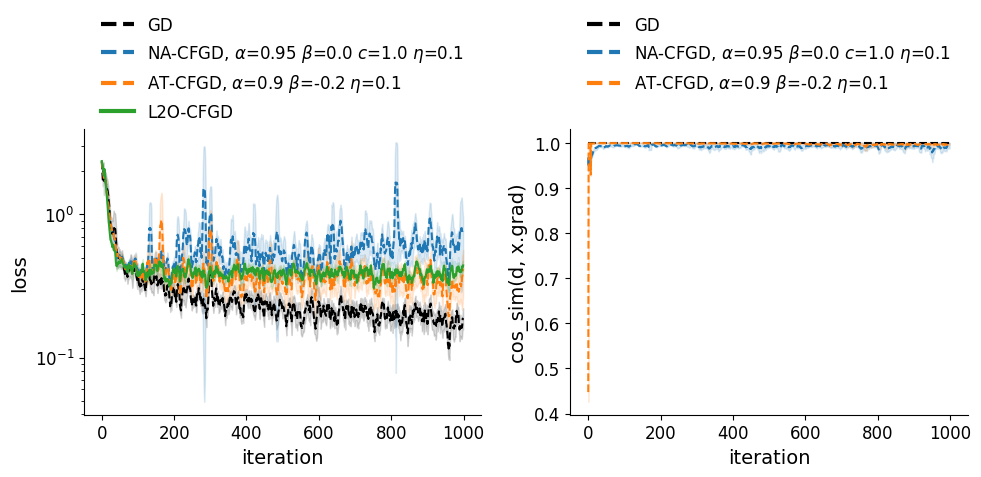

In [19]:
conv_win = 5
plot_log(
    runs,
    only_metrics=["loss", "cos_sim(d, x.grad)"],
    log_metrics=["loss", "l2_dist(x_tik*, x)", "l2_dist(x*, x)"],
    conv_win=conv_win,
    min_max_y_config={
        "last_lr": (0, 100),
    },
    # save_to=os.path.join(
    #     config["ckpt_config"]["ckpt_dir"],
    #     f"loss_cos_sim_l2o_best_dict_1600_{conv_win}conv_{n_test_runs}runs_{test_run_iters}iters.png"
    # ),
)

In [ ]:
apply_publication_plt_settings(font_size=16, dpi=600, figsize=(5, 3.5))

In [20]:
apply_publication_plt_settings(font_size=15, dpi=600, figsize=(13, 8))

In [22]:
### collect
# gammas = np.stack(runs["L2O + CFGD_ClosedForm"]["log"]["gamma"])
# gammas = gammas.T.diagonal().transpose(1, 0, 2)  # (n_test_runs, n_iters, D)

alphas = np.stack(runs["L2O-CFGD"]["log"]["alpha"]).reshape(n_test_runs, test_run_iters, -1)
betas = np.stack(runs["L2O-CFGD"]["log"]["beta"]).reshape(n_test_runs, test_run_iters, -1)
cs = np.stack(runs["L2O-CFGD"]["log"]["c"]).reshape(n_test_runs, test_run_iters, -1)  # (n_test_runs, n_iters, D)
# grads = np.stack(runs["L2O-CFGD"]["log"]["grad"]).reshape(n_test_runs, test_run_iters, -1)  # (n_test_runs, n_iters, D)

In [23]:
max_components = 400
component_idxs = np.random.choice(alphas.shape[-1], size=max_components, replace=False)

In [ ]:
test_run_idx = 0
iters_to_show = [0, 1, 2, 5, 20]

# fig = plt.figure(figsize=(14, 18), facecolor="white")
fig = plt.figure()
# fig.suptitle("L2O + CFGD_ClosedForm")
ax_idx = 1

for i, iter_idx in enumerate(iters_to_show):
    ax = fig.add_subplot(len(iters_to_show), 3, ax_idx)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ### alphas
    sns.scatterplot(
        # x=grads[test_run_idx, iter_idx, component_idxs],
        # y=alphas[test_run_idx, iter_idx, component_idxs],
        x=grads[:, iter_idx, component_idxs],
        y=alphas[:, iter_idx, component_idxs],
        ax=ax,
    )
    if i == len(iters_to_show) - 1:
        ax.set_xlabel(r"$\partial_{x_j} f(x_j)$")
    ax.set_ylabel(r"$\alpha$")
    # ax.set_title(fr"Iteration {iter_idx}")

    ### betas
    ax = fig.add_subplot(len(iters_to_show), 3, ax_idx + 1)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    sns.scatterplot(
        x=grads[test_run_idx, iter_idx, component_idxs],
        y=betas[test_run_idx, iter_idx, component_idxs],
        ax=ax,
    )
    if i == len(iters_to_show) - 1:
        ax.set_xlabel(r"$\partial_{x_j} f(x_j)$")
    ax.set_ylabel(r"$\beta$")
    ax.set_title(fr"Iteration {iter_idx}", pad=10)
    # ax.set_title(fr"$\beta$ (iter {iter_idx})")

    ### cs
    ax = fig.add_subplot(len(iters_to_show), 3, ax_idx + 2)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    sns.scatterplot(
        x=grads[test_run_idx, iter_idx, component_idxs],
        y=cs[test_run_idx, iter_idx, component_idxs],
        ax=ax,
    )
    if i == len(iters_to_show) - 1:
        ax.set_xlabel(r"$\partial_{x_j} f(x_j)$")
    ax.set_ylabel(r"$c$")
    # ax.set_title(fr"$c$ (iter {iter_idx})")

    ax_idx += 3

# fig.tight_layout(h_pad=1.5)
# save_to = os.path.join(
#     config["ckpt_config"]["ckpt_dir"],
#     f"strategy_grad_alpha_beta_c_{test_d}d_{test_m}m_{n_test_runs}runs_{test_run_iters}iters.png"
# )
# fig.savefig(save_to)
plt.tight_layout(h_pad=2.2)
plt.show()

# fig.savefig("../results/strategy.eps", bbox_inches="tight")

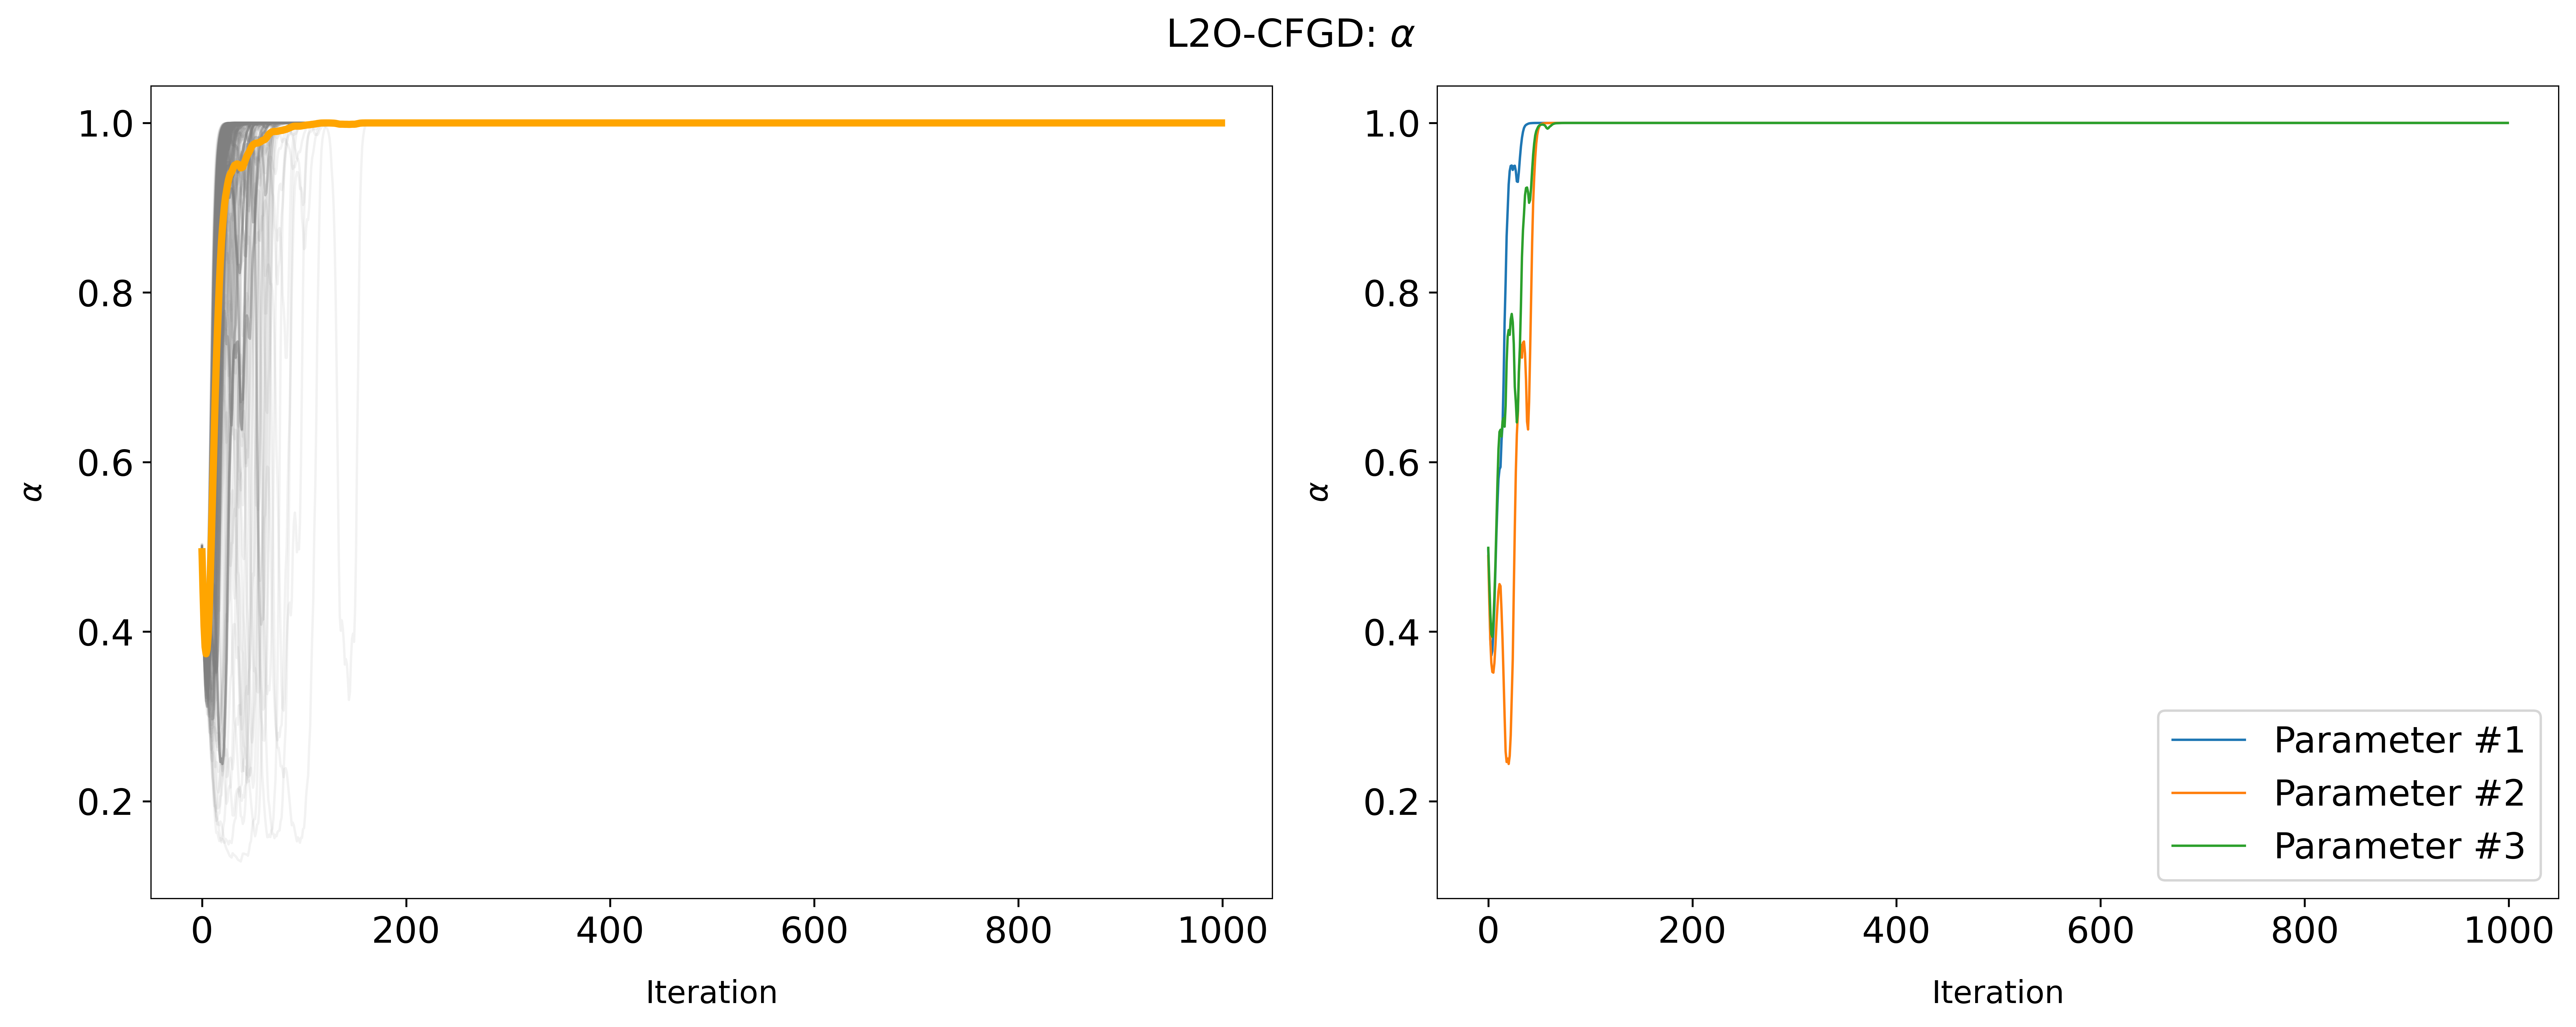

In [25]:
test_run_idx = 0
to_plot_name = "alpha"
plot_plot_label = r"$\alpha$"
log_plot = False

fig = plt.figure(figsize=(15, 6), facecolor="w")
fig.suptitle(rf"L2O-CFGD: {plot_plot_label}", fontsize=16)

ax = fig.add_subplot(121)
if to_plot_name == "alpha":
    to_plot = alphas[:,:,component_idxs]
elif to_plot_name == "beta":
    to_plot = betas[:,:,component_idxs]
elif to_plot_name == "gamma":
    to_plot = gammas[:,:,component_idxs]
elif to_plot_name == "c":
    to_plot = cs[:,:,component_idxs]
elif to_plot_name == "grad":
    to_plot = grads[:,:,component_idxs]
else:
    raise ValueError(f"Unknown to_plot: {to_plot_name}")

plt.plot(to_plot[test_run_idx].squeeze().reshape(1000, -1), alpha=0.1, color="grey")
plt.plot(to_plot[test_run_idx].squeeze().reshape(1000, -1).mean(-1), color="orange", linewidth=3)
ax.set_xlabel("Iteration", fontsize=13)
ax.set_ylabel(plot_plot_label, fontsize=13)

### share y-axis with left plot
ax = fig.add_subplot(122, sharey=ax)
plt.plot(to_plot[test_run_idx].squeeze().reshape(1000, -1)[:,:3])
ax.set_xlabel("Iteration", fontsize=13)
ax.set_ylabel(plot_plot_label, fontsize=13)
ax.legend(["Parameter #1", "Parameter #2", "Parameter #3"])

if log_plot:
    ax.set_yscale("log")

plt.tight_layout(h_pad=2.5)
# save_to = os.path.join(
#     config["ckpt_config"]["ckpt_dir"],
#     f"strategy_{to_plot_name}_{n_test_runs}runs_{test_run_iters}iters.png"
# )
# fig.savefig(save_to)

fig.savefig("../results/strategy.eps", bbox_inches="tight")

In [26]:
### save stats about the L2O-CFGD strategy
alphas_mean = alphas.mean((0,2))
betas_mean = betas.mean((0,2))
cs_mean = cs.mean((0,2))

In [27]:
run_name_clean = ''.join(e for e in run_name if e.isalnum())
run_nickname = f"L2OCFGD__{dict_to_str(runs['L2O-CFGD']['config']['optee']['optee_config'])}__{n_test_runs}runs_{test_run_iters}iters_{test_runs_seed}seed"
save_to = os.path.join(runs["L2O-CFGD"]["config"]["ckpt_config"]["ckpt_dir"], run_nickname + "_stats" + ".pt")
run_nickname, save_to

('L2OCFGD__{layer_sizes=[20]_act_fn=ReLU}__3runs_1000iters_1seed',
 '/home/datalab/notebooks/JanSobotka/fl2o/fractional-learning-to-optimize/ckpt/l2o/04-02_11-17__L2O__CFGD/L2OCFGD__{layer_sizes=[20]_act_fn=ReLU}__3runs_1000iters_1seed_stats.pt')

In [29]:
save_to = os.path.join(runs["L2O-CFGD"]["config"]["ckpt_config"]["ckpt_dir"], run_nickname + "_stats" + ".pt")
torch.save({
    "alphas": alphas,
    "betas": betas,
    "cs": cs,
    # "grads": grads,
    # "gammas": gammas,
}, save_to, pickle_module=dill)

#### Run LCFGD

In [30]:
### collect
# gammas = np.stack(runs["L2O + CFGD_ClosedForm"]["log"]["gamma"])
# gammas = gammas.T.diagonal().transpose(1, 0, 2)  # (n_test_runs, n_iters, D)

alphas = np.stack(runs["L2O-CFGD"]["log"]["alpha"]).reshape(n_test_runs, test_run_iters, -1)
alphas_mean = alphas.mean((0,2))
betas = np.stack(runs["L2O-CFGD"]["log"]["beta"]).reshape(n_test_runs, test_run_iters, -1)
betas_mean = betas.mean((0,2))
cs = np.stack(runs["L2O-CFGD"]["log"]["c"]).reshape(n_test_runs, test_run_iters, -1)  # (n_test_runs, n_iters, D)
cs_mean = cs.mean((0,2))
# grads = np.stack(runs["L2O-CFGD"]["log"]["grad"]).reshape(n_test_runs, test_run_iters, -1)  # (n_test_runs, n_iters, D)


In [41]:
alphas_to_set = torch.ones(test_run_iters)
alphas_to_set[:5] = 0.1
alphas_to_set[5:20] = 0.5
alphas_to_set[20:50] = 0.9
alphas_to_set[50:] = 0.99

# cs_to_set = torch.zeros(test_run_iters)
# cs_to_set[:5] = -0.5
# cs_to_set[5:20] = 0.1

In [37]:
lcfgd_run_name = r"LCFGD lr=0.1 ($\alpha$)"
runs[lcfgd_run_name] = dict()
lcfgd_config = {
    "update_config": {
        **update_config_base,
        "opter": {
            "opter_cls": CFGD,
            "opter_config": {
                "lr": 0.1,
                # "alpha": 0.99,
                # "alpha": torch.from_numpy(alphas_mean).to(DEVICE),
                "alpha": alphas_to_set.to(DEVICE),
                # "beta": torch.from_numpy(betas_mean).to(DEVICE),
                # "c": torch.from_numpy(cs_mean).to(DEVICE),
                # "c": cs_to_set.to(DEVICE),
                "c": None,
                "s": 1,
                "version": "AT",
                "init_points": None,
                "device": DEVICE,
            },
        },
    },
    "plot_config": {
        "linestyle": "dashed",
    },
}
runs[lcfgd_run_name]["config"] = copy.deepcopy(config)
runs[lcfgd_run_name]["config"].update(lcfgd_config["update_config"])
runs[lcfgd_run_name]["config"]["data"]["data_config"]["device"] = DEVICE
runs[lcfgd_run_name]["plot_config"] = lcfgd_config["plot_config"]
runs[lcfgd_run_name]["config"]["device"] = DEVICE

lcfgd_log = do_fit(
    opter_cls=runs[lcfgd_run_name]["config"]["opter"]["opter_cls"],
    opter_config=runs[lcfgd_run_name]["config"]["opter"]["opter_config"],
    optee_cls=runs[lcfgd_run_name]["config"]["optee"]["optee_cls"],
    optee_config=runs[lcfgd_run_name]["config"]["optee"]["optee_config"],
    data_cls=runs[lcfgd_run_name]["config"]["data"]["data_cls"],
    data_config=runs[lcfgd_run_name]["config"]["data"]["data_config"],
    n_iters=runs[lcfgd_run_name]["config"]["n_iters"],
    l2o_dict=runs[lcfgd_run_name]["config"]["l2o_dict"],
    in_meta_training=False,
    additional_metrics=runs[lcfgd_run_name]["config"]["additional_metrics"],
)[0]

### append log
runs[lcfgd_run_name]["log"] = dict()
for metric_name in lcfgd_log.keys():
    if metric_name not in runs[lcfgd_run_name]["log"]:
        runs[lcfgd_run_name]["log"][metric_name] = []
    runs[lcfgd_run_name]["log"][metric_name].append(lcfgd_log[metric_name])

In [39]:
### reorder runs
# runs = {
#     "GD": runs["GD"],
#     "L2O-CFGD": runs["L2O-CFGD"],
# }

### clear runs
ks = list(runs.keys())
for k in ks:
    if "lcfgd" in k.lower():
        del runs[k]

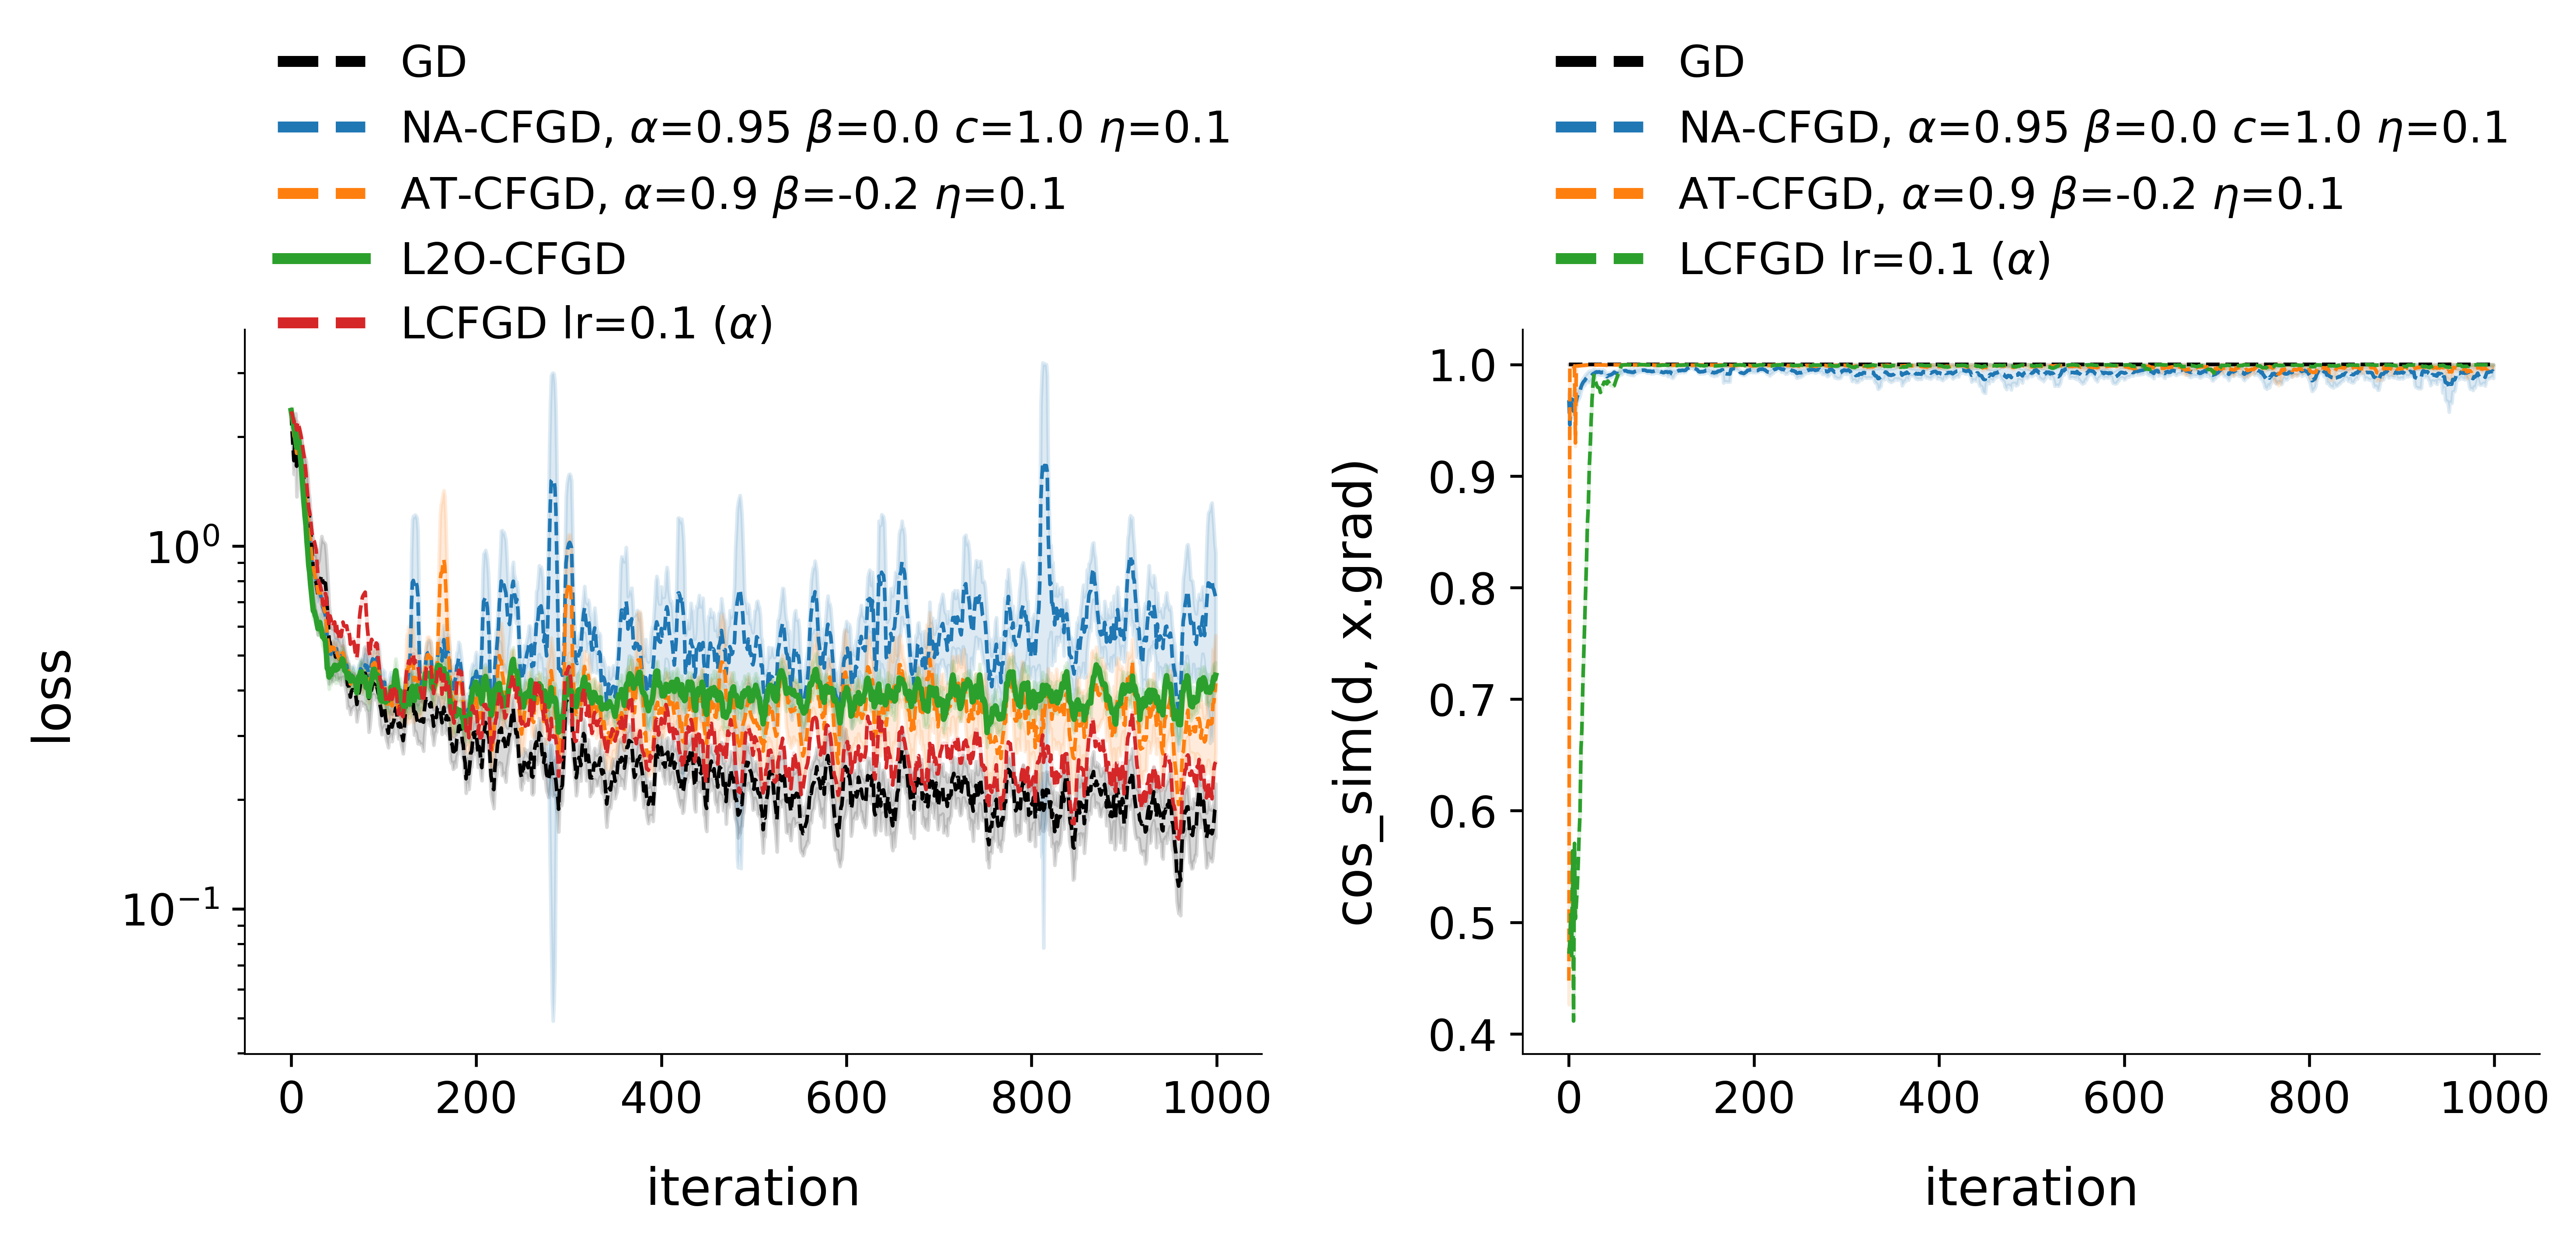

In [40]:
### plot
conv_win = 8
plot_log(
    runs,
    only_metrics=["loss", "cos_sim(d, x.grad)"],
    log_metrics=["loss", "l2_dist(x_tik*, x)", "l2_dist(x*, x)"],
    conv_win=conv_win,
    min_max_y_config={
        "last_lr": (0, 100),
    },
    # save_to=os.path.join(
    #     config["ckpt_config"]["ckpt_dir"],
    #     f"loss_cos_sim_l2o_best_dict_{conv_win}conv_{n_test_runs}runs_{test_run_iters}iters.png"
    # ),
)